In [5]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.init as init
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

In [6]:
file = h5py.File(r'C:\Users\rosel\Downloads\dataset.hdf5', 'r')
csm = np.array(file['trnCsm'])  # Coil sensitivity map
x_i = np.array(file['trnOrg'])  # Ground truth (original, high quality MRI images)
P_i = np.array(file['trnMask'])  # Corresponding sampling operator
file.close()

In [7]:
#DATA PREPROCESSING
def normalize_images(images):
    normalized_images = np.empty(images.shape, dtype=np.float32)
    # Normalize each image based on the magnitude of complex numbers
    for i, image in enumerate(images):
        magnitude = np.abs(image) 
        min_val = magnitude.min()
        max_val = magnitude.max()
        range_val = max_val - min_val
        normalized_images[i] = (magnitude - min_val) / range_val
    return normalized_images

normalized_x_i = normalize_images(x_i) #normalize ground truth images
y_i = [] #undersampled k-space data (frequency domain data)
xbi = [] #zero-filled images

def forward_calculation(image, coil_sensitivity, undersampling_mask, num_rows, num_cols, num_coils):
    # Convert spatial domain data to frequency domain data (ground truth to k-space)
    # Reshape and replicate the image for each coil
    combined_image = np.reshape(image, (num_rows, num_cols))
    coil_combined_images = np.tile(combined_image, [num_coils, 1, 1]) * coil_sensitivity

    # Apply Fourier Transform
    kspace = np.fft.fft2(coil_combined_images) / np.sqrt(num_rows * num_cols)

    # Check and adjust the shape of the mask (if mask has two dimension-designed for a single coil)
    if len(undersampling_mask.shape) == 2:
        undersampling_mask = np.tile(undersampling_mask, (num_coils, 1, 1))

    # Apply the undersampling mask
    res = kspace[undersampling_mask != 0]
    return res

def adjoint_calculation(kspace_under, coil_sensitivity, undersampling_mask, num_rows, num_cols, num_coils):
    # Convert frequency domain data back to spatial domain
    # Initialize an empty array to store the combined coil image
    temp = np.zeros((num_coils, num_rows, num_cols), dtype=np.complex64)

    # Check and adjust the shape of the mask
    if len(undersampling_mask.shape) == 2:
        undersampling_mask = np.tile(undersampling_mask, (num_coils, 1, 1))

    # Reshape kspace_under to a 3D array 
    kspace_under_reshaped = kspace_under.reshape(num_coils, -1)

    # Assign undersampled k-space data to the corresponding locations in temp
    for coil_index in range(num_coils):
        coil_mask = undersampling_mask[coil_index]
        temp[coil_index][coil_mask != 0] = kspace_under_reshaped[coil_index, :coil_mask.sum()]

    # Perform Inverse FFT and combine coil images
    inverse_fft_img = np.fft.ifft2(temp) * np.sqrt(num_rows * num_cols)
    combined_coil_image = np.sum(inverse_fft_img * np.conj(coil_sensitivity), axis=0).astype(np.complex64)

    return combined_coil_image

for i in range(normalized_x_i.shape[0]):
    num_rows, num_cols = normalized_x_i[i].shape
    num_coils = csm.shape[1]
    # Forward calculation
    undersampled_kspace = forward_calculation(
        normalized_x_i[i], csm[i], P_i[i], num_rows, num_cols, num_coils)
    y_i.append(undersampled_kspace)
    # Adjoint calculation
    reconstructed_image = adjoint_calculation(
        undersampled_kspace, csm[i], P_i[i], num_rows, num_cols, num_coils)
    xbi.append(reconstructed_image)

normalized_xbi = normalize_images(np.array(xbi))
    
# Split the data into training, validation, and testing sets
x_bi_train_test, x_bi_val, x_i_train_test, x_i_val = train_test_split(normalized_xbi, normalized_x_i, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
x_bi_train, x_bi_test, x_i_train, x_i_test = train_test_split(x_bi_train_test, x_i_train_test, test_size=0.25, random_state=42)

In [4]:
def handle_complex(data):
    # Assuming 'data' is a numpy array of complex numbers
    real_part = data.real
    imag_part = data.imag
    # Stack the real and imaginary parts as separate channels
    processed_data = np.stack((real_part, imag_part), axis=1)  # Change axis to 1 for PyTorch's NCHW format
    return processed_data

x_bi_train = handle_complex(x_bi_train)
x_bi_val = handle_complex(x_bi_val)
x_i_train = handle_complex(x_i_train) #256x232 pixel images with 2 channels (real/imaginary complex)
x_i_val = handle_complex(x_i_val)
x_bi_test = handle_complex(x_bi_test)
x_i_test = handle_complex(x_i_test)

print("Shape of x_bi_train:", x_bi_train.shape)
print("Shape of x_bi_val:", x_bi_val.shape)

#pytorch 
class DnCNN(nn.Module):
    def __init__(self, depth=17, n_channels=64, image_channels=2, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        padding = 1
        layers = [nn.Conv2d(image_channels, n_channels, kernel_size, padding, bias=True), nn.ReLU(inplace=True)]
        for _ in range(depth-2):
            layers.append(nn.Conv2d(n_channels, n_channels, kernel_size, padding, bias=not use_bnorm))
            if use_bnorm:
                layers.append(nn.BatchNorm2d(n_channels))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(n_channels, image_channels, kernel_size, padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        return self.dncnn(x)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

# Assuming tensors x_bi_train, x_i_train, etc. are pre-defined and loaded correctly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DnCNN().to(device).half()  # Using half precision
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Data loading
train_loader = DataLoader(TensorDataset(x_bi_train, x_i_train), batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(TensorDataset(x_bi_val, x_i_val), batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(TensorDataset(x_bi_test, x_i_test), batch_size=32, shuffle=False, num_workers=4)

# Training and validation loops
num_epochs = 7
for epoch in range(num_epochs):
    model.train()
    for x_bi, x_i in train_loader:
        x_bi, x_i = x_bi.to(device).half(), x_i.to(device).half()  # Converting to half precision
        optimizer.zero_grad()
        outputs = model(x_bi)
        loss = criterion(outputs, x_i)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_loss = sum(criterion(model(x_bi.to(device).half()), x_i.to(device).half()).item() for x_bi, x_i in val_loader) / len(val_loader)
    print(f"Epoch {epoch}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}")

Shape of x_bi_train: (216, 2, 256, 232)
Shape of x_bi_val: (72, 2, 256, 232)


TypeError: 'int' object is not callable

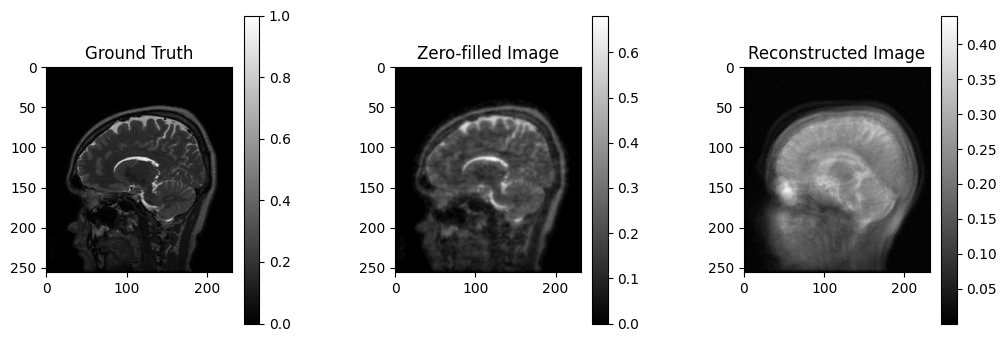

In [29]:
def plot_magnitude_images(tensor, title="Image"):
    # Assuming the tensor is of shape (N, 2, H, W) and contains real and imaginary parts
    tensor = tensor.permute(0, 2, 3, 1).detach().numpy()  # Convert to NHWC format for easier manipulation
    complex_images = tensor[..., 0] + 1j * tensor[..., 1]
    magnitudes = np.abs(complex_images)

    plt.figure(figsize=(12, 4))
    for i, mag in enumerate(magnitudes):
        plt.subplot(1, len(magnitudes), i+1)
        plt.imshow(mag, cmap='gray')
        plt.title(f"{title} {i+1}")
        plt.colorbar()
    plt.show()

def plot_images(normalized_x_i, x_bi, reconstructed_images):
    plt.figure(figsize=(12, 4))  # Adjust the figure size as needed

    # Plot Ground Truth Image
    plt.subplot(1, 3, 1)
    # Assuming normalized_x_i is a complex data split into real and imaginary parts
    ground_truth_complex = normalized_x_i[0, ..., 0] + 1j * normalized_x_i[0, ..., 1]
    plt.imshow(np.abs(ground_truth_complex), cmap='gray')
    plt.title('Ground Truth')
    plt.colorbar()

    # Plot Zero-filled Image
    plt.subplot(1, 3, 2)
    # Assuming x_bi is a complex data split into real and imaginary parts
    zero_filled_complex = x_bi[0, ..., 0] + 1j * x_bi[0, ..., 1]
    plt.imshow(np.abs(zero_filled_complex), cmap='gray')
    plt.title('Zero-filled Image')
    plt.colorbar()

    # Plot Reconstructed Image
    plt.subplot(1, 3, 3)
    # Assuming reconstructed_images are stored with real and imaginary parts as separate channels
    reconstructed_complex = reconstructed_images[0, ..., 0] + 1j * reconstructed_images[0, ..., 1]
    magnitude = np.abs(reconstructed_complex)
    plt.imshow(magnitude, cmap='gray')
    plt.title('Reconstructed Image')
    plt.colorbar()

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    plt.show()

In [ ]:
#Calculate PSNR and SSIM values
reconstructed_images = model.predict(x_bi_test)
psnr_values = []
ssim_values = []
for original, reconstructed in zip(x_i_test, reconstructed_images):
    # Compute PSNR
    psnr_value = psnr(original, reconstructed, data_range=original.max() - original.min())
    psnr_values.append(psnr_value)
    # Compute SSIM with smaller window size
    ssim_value = ssim(original, reconstructed, data_range=original.max() - original.min(), win_size=5, channel_axis=-1)
    ssim_values.append(ssim_value)

# Compute average PSNR and SSIM values
avg_psnr = np.mean(psnr_values)
avg_ssim = np.mean(ssim_values)

print("Average PSNR:", avg_psnr)
print("Average SSIM:", avg_ssim)